# Perfect tests 

The first model supposes the samples are independent and the test is perfect,
which means that $\theta_i = p_i$ for all $i$. Therefore it only considers the risk factors $\boldsymbol{x}_i$. 

\begin{equation}
  \begin{aligned}
    T_i &\sim \operatorname{Bernoulli}(\theta_i), \\
    g(\theta_i) &= g(\theta) + \boldsymbol{x}_i^T\beta, 
  \end{aligned}  
\end{equation}

where $v^T$ denotes the transpose of $v$, and $g(\cdot)$ is a link function.
The parameter $\beta \in \mathbb{R}^{k}$ is the risk effects. For Bayesian inference, priors on
$\beta$ and $\theta$ must be included. We use $\beta ~ \sim \operatorname{Normal}(\mu, \Sigma)$
and $\theta \sim \operatorname{Beta}(a^{p}, b^p)$, where $\mu
\in \mathbb{R}^{k}$, $\Sigma \in \mathbb{R}^{k\times k}$ symmetric positive-definite matrix,
$a^p \in \mathbb{R}_{++}$, and $b^p \in \mathbb{R}_{++}$
are fixed hyperparameters. 

In [1]:
import numpy as np
import pystan as ps
from scipy.special import logit, expit

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pickle
from tqdm import tqdm

import sys  
sys.path.insert(0, '../scripts/')

## Notebook settings

In [2]:
sns.set()
plt.rc('mathtext', fontset="cm")
ro = np.random.RandomState(1000)
%matplotlib inline

## Stan model 

As usual, we can saved a compiled version for future experiments. 

In [3]:
#compiled = False
compiled = True

if compiled: 
    sm = pickle.load(open('../models/primary_model/pickles/perfect_test.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/primary_model/stan_codes/perfect_test.stan')
    with open('../models/primary_model/pickles/perfect_test.pkl', 'wb') as f:
        pickle.dump(sm, f)

The simpler model is what follows written in Stan. 

In [4]:
print(sm.model_code)

data {
    int<lower = 0> n_samples;
    int<lower = 0> n_predictors; 
  
    int T[n_samples];
    matrix[n_samples, n_predictors] x;
    
    cov_matrix[n_predictors] Sigma; 
    vector[n_predictors] mu;
    real<lower = 0> alpha_p; 
    real<lower = 0> beta_p;
}
parameters {
    vector[n_predictors] effects; 
    real<lower = 0, upper = 1> prev; 
}
model {
    effects ~ multi_normal(mu, Sigma);
    prev ~ beta(alpha_p, beta_p);

    for (i in 1:n_samples) {
       T[i] ~ bernoulli_logit(logit(prev) + x[i] * effects);
    }
}
generated quantities {
  vector[n_predictors] effects_prior = multi_normal_rng(mu, Sigma); 
  real<lower = 0, upper = 1> prev_prior = beta_rng(alpha_p, beta_p);  
}


## Toy example

First we describe data created artificially as it was generated by this model.
It serves as a confirmation of functionality of the code. 

In [5]:
n_samples    = 500
n_predictors = 1
  
x = ro.multivariate_normal(mean = [15], 
                           cov = np.eye(n_predictors),
                           size = n_samples)

In [6]:
# Normalization
x_norm = (x - x.mean(axis=0)) #/x.std(axis = 0, ddof = 0)

andAnd now we define the parameters we want to estimate

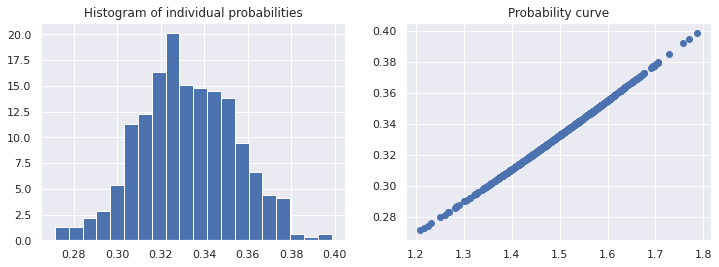

In [20]:
beta = np.array([0.1]).reshape(-1,1)
prevalence = 0.1
theta = expit(logit(prevalence) + x@beta)

T = ro.binomial(n = 1, p = theta)

fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].hist(theta, density = True, bins = 20)
ax[1].scatter(x@beta, theta)
ax[0].set_title('Histogram of individual probabilities')
ax[1].set_title('Probability curve')

plt.show()

In [21]:
data = {
    "n_samples"    : n_samples,
    "n_predictors" : n_predictors,
    "T"            : T.flatten(),
    "x"            : x,
}

T.mean()

0.346

Now we describe the necessary pieces to the model. 

In [22]:
Sigma   = np.eye(1)
mu      = np.zeros(1)
alpha_p = 1
beta_p  = 1

data.update({
    "Sigma"        : Sigma,
    "mu"           : mu,
    "alpha_p"      : alpha_p,
    "beta_p"       : beta_p
})

How the numerical part of the problem enters the picture

In [23]:
%%time
fit_perfect = sm.sampling(data=data, iter=4000)
summary = az.summary(fit_perfect)

CPU times: user 248 ms, sys: 112 ms, total: 360 ms
Wall time: 16.1 s


The summary

In [18]:
summary.insert(0, 'real_values', (*tuple(beta.flatten()), prevalence, 0, 0))
summary

,real_values,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
effects[0],0.1,0.268,0.153,-0.021,0.557,0.002,0.001,5561.0,5263.0,1.0
prev,0.1,0.091,0.013,0.067,0.115,0.000,0.000,5819.0,5493.0,1.0
effects_prior[0],0.0,-0.018,1.007,-1.938,1.819,0.011,0.008,8014.0,7754.0,1.0
prev_prior,0.0,0.499,0.288,0.006,0.942,0.003,0.002,7836.0,7379.0,1.0


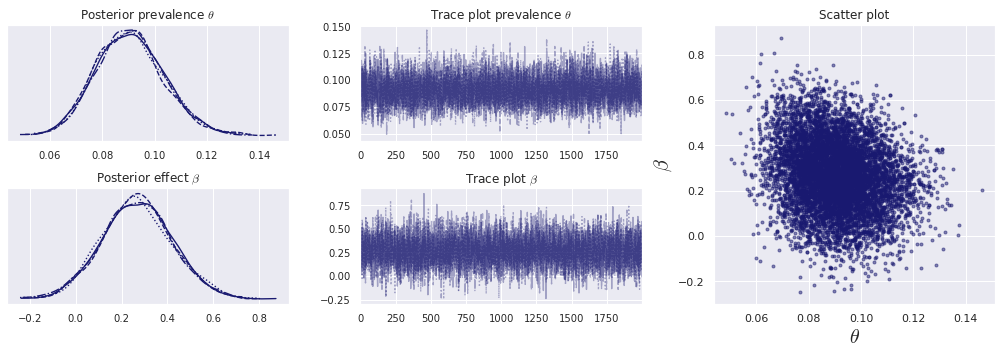

In [19]:
fig, ax = plt.subplots(2,3, figsize = (14,5))
az.plot_trace(fit_perfect, var_names=('prev', 'effects'), kind = 'trace', axes = ax, 
              chain_prop={'color': ['midnightblue'], 'linestyle': ['-', '--', '-.', ':']})

ax[0,0].set_title(r'Posterior prevalence $\theta$')
ax[0,1].set_title(r'Trace plot prevalence $\theta$')
ax[1,0].set_title(r'Posterior effect $\beta$')
ax[1,1].set_title(r'Trace plot $\beta$')

gs = ax[0, 2].get_gridspec()
# remove the underlying axes
for i in ax[0:, -1]:
    i.remove()
axbig = fig.add_subplot(gs[0:, -1])

az.plot_pair(
    fit_perfect, var_names=["prev", "effects"], scatter_kwargs = {'color': 'midnightblue', 'alpha': 0.5}, 
    ax = axbig
)
axbig.set_ylabel(r"$\beta$", fontsize = 20)
axbig.set_xlabel(r"$\theta$", fontsize = 20)
axbig.set_title('Scatter plot')

fig.tight_layout(pad=1.0)
plt.savefig('../images/identifiability_perfect_tests_scaled_x.pdf', bbox_inches = 'tight')
plt.show()

## Practical identifiability

Varying $\beta_1$ value (the intercept) with prevalence fixed. The ideia is to
verify some correlation (numerically) between these parameters. 

In [12]:
x_test = ro.multivariate_normal(mean = np.zeros(1), 
                                cov = np.eye(1),
                                size = 100) 

data_test = {
    "n_samples"    : 100,
    "n_predictors" : 1,
    "x"            : x_test,  
    "Sigma"        : np.eye(1), 
    "mu"           : np.zeros(1),
    "alpha_p"      : 1, 
    "beta_p"       : 3,
    "T"            : 0
}

values = []

for each in tqdm(range(100)): 
    
    beta_test = ro.uniform(-2,2, size=(1,1))
    theta = expit(logit(prevalence) + x_test@beta_test)
    T = ro.binomial(n = 1, p = theta)
    
    data_test.update({
        "T"            : T.flatten(),
    })

    fit_test = sm.sampling(data=data_test) 
    prev_estimated = fit_test.extract()['prev'].mean()
        
    values.append((beta_test[0,0], prev_estimated))
    
values = np.array(values)

100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


Correlation: -0.05342196912971737


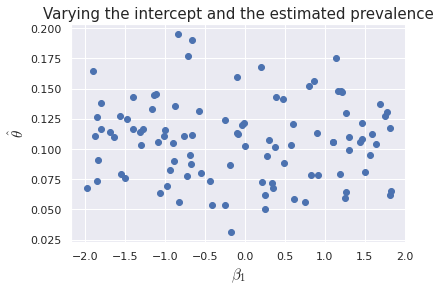

In [13]:
plt.scatter(values[:,0], values[:,1])
print("Correlation: {}".format(np.corrcoef(values[:,0], values[:,1])[0,1]))
plt.xlabel(r'$\beta_1$', fontsize = 15)
plt.ylabel(r'$\hat{\theta}$', fontsize = 15)
plt.title('Varying the intercept and the estimated prevalence', fontsize = 15)
plt.show()

### Priors

Given the priors on the prevalence and on the effects, how it is behaved on the observation-level. 

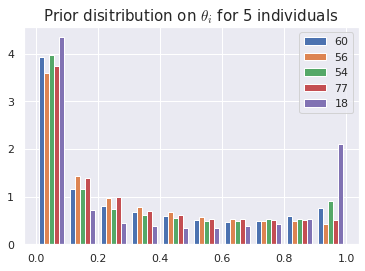

In [14]:
samples = fit_perfect.extract()

ind_prior = expit((logit(samples['prev_prior']) + x@samples['effects_prior'].T))
chosen_individuals = np.random.randint(100,size=5)
plt.hist([ind_prior[i] for i in chosen_individuals], 
         density = True, label = chosen_individuals)
plt.title(r'Prior disitribution on $\theta_i$ for 5 individuals', fontsize = 15)
plt.legend()
plt.show()